### Let's start with downloading the raw data

In [17]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [34]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'customer_complaints',
    'source': 'kaggle', # ['kaggle', 'local', 'openml', 'hf']
    'remote_path': 'selener/consumer-complaint-database',
    'files': ['rows.csv'],
    'rename_files': ['customer_complaints.csv'],
    'task': 'clf', # ['reg', 'clf']
    'target': 'Company response to consumer',
}

In [19]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /media/martin/martin_work/TabAdap_Project/datasets_notebooks/classification/../../datasets_files/raw/classification/customer_complaints.
Downloaded customer_complaints dataset to /media/martin/martin_work/TabAdap_Project/datasets_notebooks/classification/../../datasets_files/raw/classification/customer_complaints


### Now we need to preprocess the data

In [20]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [21]:
# TODO: we will downsample the dataset to ~24k samples

import os
import pandas as pd

# Define the path
current_dir = os.getcwd()
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)
                                                                                                                    
# File paths
train_path = os.path.join(download_path, dataset_config['rename_files'][0])

# Load safely, skipping bad lines
train_df = pd.read_csv(train_path, on_bad_lines='skip', engine='python')

# Downsample with fallback if not enough rows
train_sample_size = min(len(train_df), 24000)

train_df = train_df.sample(n=train_sample_size, random_state=42).reset_index(drop=True)

# Save back (overwrite the originals)
train_df.to_csv(train_path, index=False)


In [22]:

dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /media/martin/martin_work/TabAdap_Project/datasets_notebooks/classification/../../datasets_files/raw/classification/customer_complaints/customer_complaints.csv


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,10/30/2014,Bank account or service,Checking account,Using a debit or ATM card,NaN,NaN,NaN,"CITIBANK, N.A.",FL,333XX,Older American,NaN,Web,11/04/2014,Closed with explanation,Yes,Yes,1093367
1,03/13/2018,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,"Hello, we have big problem, there is a foreclo...",NaN,NATIONSTAR MORTGAGE,CA,957XX,NaN,Consent provided,Web,03/13/2018,Closed with explanation,Yes,NaN,2841318
2,11/13/2012,Mortgage,Other mortgage,Other,NaN,NaN,NaN,HSBC NORTH AMERICA HOLDINGS INC.,GA,30253,NaN,NaN,Referral,11/15/2012,Closed with explanation,Yes,No,190014


In [25]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []
missing_ratio_threshold = 0.5 # TODO the threshold can be changed

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=missing_ratio_threshold)   
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index(['Consumer complaint narrative', 'Company public response', 'Tags'], dtype='object')
Dataframe shape before/afrer cleaning: (24000, 18) / (24000, 15)


In [26]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['Complaint ID','Date sent to company','Timely response?','Consumer disputed?']

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")

dataset_files_cleaned[0].head(n=3)

Dataframe shape before/afrer by-hand cleaning: (24000, 15) / (24000, 11)


,Date received,Product,Sub-product,Issue,Sub-issue,Company,State,ZIP code,Consumer consent provided?,Submitted via,Company response to consumer
0,10/30/2014,Bank account or service,Checking account,Using a debit or ATM card,NaN,"CITIBANK, N.A.",FL,333XX,NaN,Web,Closed with explanation
1,03/13/2018,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,NATIONSTAR MORTGAGE,CA,957XX,Consent provided,Web,Closed with explanation
2,11/13/2012,Mortgage,Other mortgage,Other,NaN,HSBC NORTH AMERICA HOLDINGS INC.,GA,30253,NaN,Referral,Closed with explanation


In [27]:
# TODO: some custom data cleaning
import copy 
import pandas as pd
import numpy as np

def clean_zip_code(series):
    """
    Cleans ZIP code values:
    - Removes non-numeric characters.
    - Truncates to first 3 digits.
    - Keeps NaN for invalid/masked ZIP codes.
    """
    cleaned = series.astype(str).str.extract(r'(\d{3})')  # Extract first 3-digit prefix
    cleaned = cleaned[0].astype('Int64')  # Convert to float (handles NaN)
    return cleaned

tmp_df = copy.deepcopy(dataset_files_cleaned)
dataset_files_by_hand_cleaned = []

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")
    
    # 1. Drop non-essential target categories & make safe copy
    to_drop = ['Closed', 'In progress', 'Untimely response', 'Closed with relief']
    df_file = df_file[~df_file[dataset_config['target']].isin(to_drop)].copy()

    # 2. Convert 'Date received' to timestamp (handle NaT safely)
    df_file['Date received'] = pd.to_datetime(df_file['Date received'], format='%m/%d/%Y', errors='coerce')
    df_file['Date received'] = df_file['Date received'].apply(lambda x: x.timestamp() if pd.notnull(x) else float('nan'))

    # 3. Clean 'ZIP code' column to remove non-numerical characters
    if 'ZIP code' in df_file.columns:
        df_file['ZIP code'] = clean_zip_code(df_file['ZIP code'])

    print(f"Dataframe shape after custom cleaning: {df_file.shape}")

    dataset_files_by_hand_cleaned.append(df_file)

# reset the dataframe list to the version before custom cleaning
dataset_files_cleaned = tmp_df



Dataframe shape before custom cleaning: (24000, 11)
Dataframe shape after custom cleaning: (23273, 11)


### Now it is time to visualize our changes

In [28]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,Date received,Product,Sub-product,Issue,Sub-issue,Company,State,ZIP code,Consumer consent provided?,Submitted via,Company response to consumer
0,1.414627e+09,Bank account or service,Checking account,Using a debit or ATM card,NaN,"CITIBANK, N.A.",FL,333,NaN,Web,Closed with explanation
1,1.520899e+09,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,NATIONSTAR MORTGAGE,CA,957,Consent provided,Web,Closed with explanation
2,1.352765e+09,Mortgage,Other mortgage,Other,NaN,HSBC NORTH AMERICA HOLDINGS INC.,GA,302,NaN,Referral,Closed with explanation


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [29]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # umerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (2): ['Date received', 'ZIP code']
Categorical columns (4): ['Product', 'Consumer consent provided?', 'Submitted via', 'Company response to consumer']
Textual columns (5): ['Sub-product', 'Issue', 'Sub-issue', 'Company', 'State']


Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [30]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

display(summary_df)  # Or print(summary_df)


,Column Name,Example Value,Type,# Categories
0,Date received,1414627200.0,numerical,~ 2589 ~
1,Product,Bank account or service,categorical,18
2,Sub-product,Checking account,textual,71
3,Issue,Using a debit or ATM card,textual,154
4,Sub-issue,Account terms,textual,201
5,Company,"CITIBANK, N.A.",textual,1318
6,State,FL,textual,60
7,ZIP code,333,numerical,~ 841 ~
8,Consumer consent provided?,Consent provided,categorical,4
9,Submitted via,Web,categorical,6


### Saving the processed data and loading it back up

In [31]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{dataset_config['dataset_name']}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    if os.path.exists(output_path):
        print(f"File {output_path} already exists. Skipping save.")
        continue

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


File /media/martin/martin_work/TabAdap_Project/datasets_notebooks/classification/../../datasets_files/raw/classification/customer_complaints/customer_complaints_processed.pkl already exists. Skipping save.


In [35]:
import os
import pandas as pd

import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( "..", "..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from configs.dataset_configs import get_a_dataset_dict

loaded_dataset_config = get_a_dataset_dict(dataset_config['dataset_name'])

file_base = loaded_dataset_config['name']
processed_filename = f"{file_base}_processed.pkl"
processed_path = os.path.join(download_path, processed_filename)

# Load the bundled dictionary (data + summary + config)
bundle = pd.read_pickle(processed_path)

# Extract components
loaded_df = bundle['data']
summary_df = bundle['summary']
loaded_config = bundle['config']

print(f"\n=== {file_base.upper()} ===")
print(f"Loaded config keys: {list(loaded_config.keys())}")

# Show metadata
meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
display(meta_df)

# Flatten for modeling
loaded_df.columns = loaded_df.columns.get_level_values(0)
display(loaded_df.head(n=3))



=== CUSTOMER_COMPLAINTS ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,Date received,numerical,~ 2589 ~
1,Product,categorical,18
2,Sub-product,textual,71
3,Issue,textual,154
4,Sub-issue,textual,201
5,Company,textual,1318
6,State,textual,60
7,ZIP code,numerical,~ 841 ~
8,Consumer consent provided?,categorical,4
9,Submitted via,categorical,6


Column Name,Date received,Product,Sub-product,Issue,Sub-issue,Company,State,ZIP code,Consumer consent provided?,Submitted via,Company response to consumer
0,1.377821e+09,Bank account or service,Checking account,Deposits and withdrawals,NaN,WELLS FARGO & COMPANY,MI,392,NaN,Phone,Closed with explanation
1,1.519603e+09,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,"EQUIFAX, INC.",PA,171,Consent provided,Web,Closed with explanation
2,1.518048e+09,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Card was charged for something you did not pur...,JPMORGAN CHASE & CO.,MI,<NA>,Consent provided,Web,Closed with explanation


### Bonus insights

Unique classes in 'Company response to consumer': ['Closed with explanation', 'Closed with non-monetary relief', 'Closed with monetary relief', 'Closed without relief']


Text(0.5, 1.0, "Distribution of 'Company response to consumer' target")

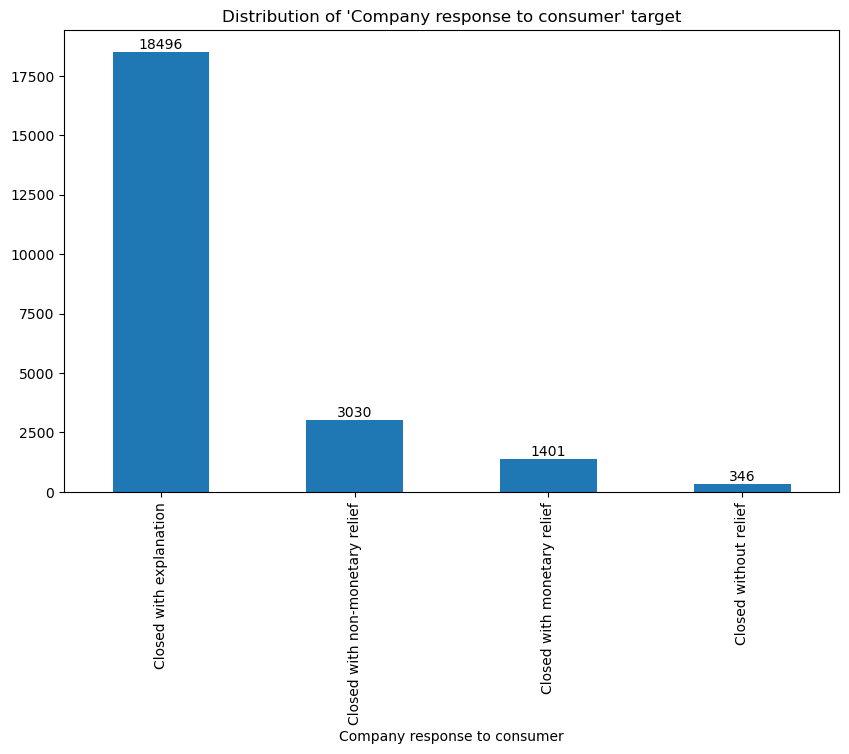

In [36]:
# show data imbalance:
import matplotlib.pyplot as plt

# Plot the distribution of player_class with counts
value_counts = loaded_df[dataset_config['target']].value_counts()

# print the unique classes
print(f"Unique classes in '{dataset_config['target']}': {value_counts.index.tolist()}")

plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')

# Add counts as text labels on top of bars
for i, count in enumerate(value_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title(f"Distribution of '{dataset_config['target']}' target")

